In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import viz

from matplotlib import pyplot as plt
from scipy.stats import linregress

colors = viz.plotting_style()
lin_colors = colors.values()

plt.style.use('style.mpl')

In [2]:
# Load E. coli growth rates from Schmidt et al. 2016
coli_data = pd.read_csv('../data/proteomes/Coli/Chure_proteome_NOSC.csv')
mask = np.logical_and(
    coli_data.dataset.str.contains('schmidt'),
    coli_data.growth_mode != 'chemostat') 
stress_conds = 'pH6,osmotic_stress_glucose,42C'.split(',')
mask = np.logical_and(mask, ~coli_data.condition.isin(stress_conds))
coli_csource_df = coli_data[mask].sort_values('growth_rate_hr')
coli_csource_df.condition.replace({'glycerol_pAA': 'glycerol + AA', 'lb_miller': 'LB'}, inplace=True)

In [3]:
# Chemostat example. Maximum growth rate exists.
kayser_chemostat_df = pd.read_csv('../data/chemostat_data/kayser_chemostat_growth_unit_conv.csv')

# Metabolic modes of E. coli
coli_modes_df = pd.read_excel('../data/physiology/coli_metabolic_modes.xlsx', index_col=0)

# Load biomass macromolecular composition from Bremer & Dennis 2008
biomass_percent_df = pd.read_csv('../data/physiology/BremerDennis2008_BiomassComposition_pct.csv', index_col=0)

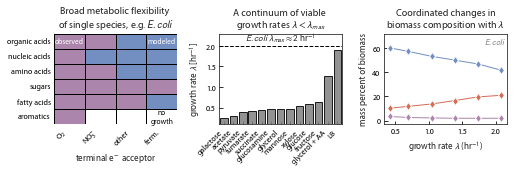

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(7.24, 2.5), 
                        gridspec_kw={'width_ratios': [1, 1, 1]})
                        
# Panel on range of metabolic modes. 
plt.sca(axs[0])
coli_modes_num = coli_modes_df.replace(
    {'experiment': 3, 'engineered': 2, 'model': 1, np.NAN: 0})
cmap = ['w'] + [colors[x] for x in 'blue,green,purple'.split(',')]
sns.heatmap(coli_modes_num, cmap=cmap, cbar=False, linewidths=0.5, linecolor='black')
plt.ylabel('')
plt.xlabel('')
tick_labels = {
    'CO2': 'CO$_2$',
    'O2': 'O$_2$', 
    'NO3': 'NO$_3^{-}$',
    'DMSO/TMAO': 'other',
    'fermentation': 'ferm.'}
my_ticks = [tick_labels[x] for x in coli_modes_num.columns]
plt.xticks(np.arange(len(my_ticks))+0.5, my_ticks, rotation=45, ha='right')
plt.title('Broad metabolic flexibility \nof single species, e.g. $E. coli$')
plt.text(0.5, 0.5, 'observed', ha='center', va='center', fontsize=7.5, color='w')
plt.text(3.5, 0.5, 'modeled', ha='center', va='center', fontsize=7.5, color='w')
plt.text(3.5, 5.5, 'no\ngrowth', ha='center', va='center', fontsize=7.5, color='k')
plt.tick_params(axis=u'both', which=u'both', length=0)
plt.xlabel('terminal e$^-$ acceptor')

# Panel on maximum growth rate -- E. coli growth rates by C-source from Schmidt 2016.
plt.sca(axs[1])
#plt.yscale('log')
sns.barplot(data=coli_csource_df, y='growth_rate_hr', x='condition', color='grey',
            alpha=0.85, edgecolor='k', lw=1)
plt.axhline(2.0, color='k', ls='--', lw=1)
plt.xticks(rotation=45, ha='right')
plt.ylim(0.1, 2.3)
plt.title('A continuum of viable \ngrowth rates $\lambda < \lambda_{max}$')
plt.text(6, 2.01, '$E. coli$ $\lambda_{max} \\approx 2$ hr$^{-1}$', va='bottom', ha='center', fontsize=9)

plt.ylabel('growth rate $\lambda$ [hr$^{-1}$]')
plt.xlabel('')

plt.sca(axs[2])
labels = 'protein,RNA,DNA'.split(',')
keys = ['{0}_percent'.format(l) for l in labels]

# Plot the fractional composition of biomass.
pal = [colors[cid] for cid in "blue,red,purple".split(",")]
for l,k,c in zip(labels, keys, pal):  
    ys = biomass_percent_df[k]
    plt.plot(biomass_percent_df.growth_rate_hr, ys, marker='d', label=l,
             markersize=6, markeredgecolor='w', lw=1, color=c)

plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel('mass percent of biomass')
plt.title('Coordinated changes in\nbiomass composition with $\lambda$')
plt.tick_params(axis='both')
plt.legend(loc=1).set_visible(False)
plt.ylim(-3, 72)
plt.text(0.99, 0.98, '$E. coli$', transform=axs[2].transAxes, ha='right', va='top',
         fontsize=8, color='grey')

plt.tight_layout()
plt.savefig('../output/Fig1.png', facecolor='white', bbox_inches='tight', dpi=300)
plt.show()

Text(0.5, 1.0, 'Heterotrophy \nis faster')

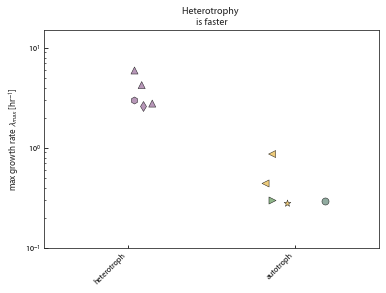

In [6]:
mask = np.logical_and(kayser_chemostat_df.D_per_h.notnull(),
                      kayser_chemostat_df.r_glucose_mmol_g_h.notnull())
masked_kayser = kayser_chemostat_df[mask]
kayser_regression = linregress(masked_kayser.D_per_h, masked_kayser.r_glucose_mmol_g_h)
kayser_regression

LinregressResult(slope=9.330509186719699, intercept=0.16059826890195206, rvalue=0.9960383317181503, pvalue=6.487887131442609e-13, stderr=0.2511634516689206, intercept_stderr=0.0669850545879041)

Text(0.5, 1.0, 'A continuum of viable \ngrowth rates $\\lambda < \\lambda_{max}$')

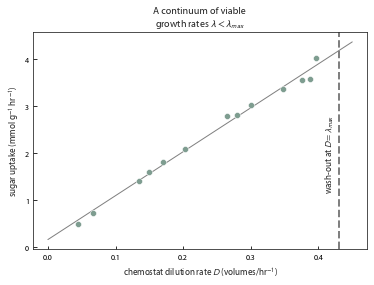

In [7]:
sns.scatterplot(data=kayser_chemostat_df, x='D_per_h', y='r_glucose_mmol_g_h', color=colors['dark_green'])

# Plot a regression
Ds = np.arange(0, masked_kayser.D_per_h.max()+0.1, 0.05)
pred_uptake = kayser_regression.slope*Ds + kayser_regression.intercept
plt.plot(Ds, pred_uptake, ls='-', lw=1, color='grey', zorder=-1)

plt.ylabel('sugar uptake (mmol g$^{-1}$ hr$^{-1}$)')
plt.xlabel('chemostat dilution rate $D$ (volumes/hr$^{-1}$)')

plt.axvline(0.43, color='grey', ls='--')
plt.text(0.417, 2, 'wash-out at $D = \lambda_{max}$', va='center', ha='center', rotation=90, fontsize=9)
plt.title('A continuum of viable \ngrowth rates $\lambda < \lambda_{max}$')